In [32]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import os
import numpy as np
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import sys
sys.path.append('./utils')
from data_utils import *
from model_utils import *
from training_utils import *

samplerate = 16000
frame_length_ms = 12
frame_length_samples = int(samplerate * frame_length_ms / 1000)
hop_length_samples = 4
channels = 128
VRP_path = '/workspace/audio'
VRP_path = r'F:\audio\test_VRP_F02'

if torch.cuda.is_available():
    print("CUDA is available. List of all available GPUs:")
    print(torch.cuda.device_count(), "GPUs available")
    for i in range(torch.cuda.device_count()):
        print("GPU", i, ":", torch.cuda.get_device_name(i))
else:
    print("CUDA is not available, using CPU instead.")

import sys
print("Python executable path:", sys.executable)

CUDA is available. List of all available GPUs:
1 GPUs available
GPU 0 : NVIDIA GeForce RTX 3070
Python executable path: g:\Conda\envs\EGG\python.exe


In [8]:
def load_data(path, samplerate=16000):
    audios = []
    eggs = []

    # Check if the path is a directory
    if os.path.isdir(path):
        # Walk through the folder
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.wav'):
                    audio_path = os.path.join(root, file)
                    try:
                        # Load file with librosa
                        wave, sr = librosa.load(audio_path, sr=samplerate, mono=False)
                        if wave.shape[0] == 2:  # Ensure it is stereo
                            audio, egg = wave[0], wave[1]
                            audios.append(audio)
                            eggs.append(egg)
                        else:
                            print(f"Skipped {audio_path}: Audio is not stereo.")
                    except Exception as e:
                        print(f"Error loading {audio_path}: {str(e)}")
    elif os.path.isfile(path) and path.endswith('.wav'):
        # It's a single file, load directly
        try:
            wave, sr = librosa.load(path, sr=samplerate, mono=False)
            if wave.shape[0] == 2:  # Ensure it is stereo
                audio, egg = wave[0], wave[1]
                audios.append(audio)
                eggs.append(egg)
            else:
                print(f"Skipped {path}: Audio is not stereo.")
        except Exception as e:
            print(f"Error loading {path}: {str(e)}")
    else:
        print(f"Error: The path provided is neither a directory nor a .wav file.")

    # Concatenate all collected data into single arrays
    audio_concat = np.concatenate(audios) if audios else np.array([])
    egg_concat = np.concatenate(eggs) if eggs else np.array([])
    return audio_concat, egg_concat

def segment_audio(audio, sr, frame_length_ms=12, hop_length_samples=160, batch_size=1000):
    frame_length_samples = int(sr * frame_length_ms / 1000)
    total_samples = audio.size

    # Initialize list to hold processed frames
    windowed_frames_list = []
    
    # Process in batches
    for start in range(0, total_samples - frame_length_samples + 1, batch_size * hop_length_samples):
        end = min(start + batch_size * hop_length_samples, total_samples)
        shape = (end - start - frame_length_samples + 1, frame_length_samples)
        strides = (audio.strides[0], audio.strides[0])
        frames = np.lib.stride_tricks.as_strided(audio[start:], shape=shape, strides=strides)
        windowed_frames_list.append(frames)
    
    # Concatenate all processed frames
    return np.concatenate(windowed_frames_list, axis=0)

def segment_audio_temp(audio, sr, frame_length_ms, hop_length_samples):
    # Convert frame length from milliseconds to samples
    frame_length_samples = int(sr * frame_length_ms / 1000)
    total_samples = len(audio)

    # Calculate the number of frames
    num_frames = (total_samples - frame_length_samples) // hop_length_samples + 1

    # Initialize an array to hold the frames
    frames = np.zeros((num_frames, frame_length_samples), dtype=np.float32)

    # Extract frames
    for i in range(num_frames):
        start_idx = i * hop_length_samples
        end_idx = start_idx + frame_length_samples
        frames[i, :] = audio[start_idx:end_idx]

    return frames

def load_and_preprocess_data(audio_path, egg_path, samplerate=16000, frame_length_ms=12, hop_length_samples=1):
    def butter_highpass(cutoff, sample_rate, order=2):
        nyquist = 0.5 * sample_rate
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
        return b, a

    def highpass_filter(data, cutoff, sample_rate, order=2):
        b, a = butter_highpass(cutoff, sample_rate, order=order)
        y = lfilter(b, a, data)
        return y

    def voice_preprocess(voice, sample_rate):
        voice = highpass_filter(voice, 30, sample_rate)
        return voice

    def process_EGG_signal(egg_signal, sample_rate, threshold_dB=-40, expansion_ratio=1/4):
        # High pass filter
        filtered_signal = apply_high_pass_filter(egg_signal, sample_rate)
        
        # Low pass filter
        filtered_signal = apply_low_pass_filter(filtered_signal, sample_rate)
        
        return filtered_signal

    def apply_high_pass_filter(signal, sample_rate=44100, numtaps=1025, cutoff=80):
        # Design the FIR filter
        fir_coeff = firwin(numtaps, cutoff, pass_zero=False, fs=sample_rate, window='hamming')

        # Apply the filter to the signal using filtfilt to avoid phase shift
        filtered_signal = filtfilt(fir_coeff, 1.0, signal)
        
        return filtered_signal

    def apply_low_pass_filter(signal, sample_rate=44100, cutoff_hz=4000, numtaps=1025):
        # Design the low-pass FIR filter with a cutoff of 10 kHz
        fir_coeff = firwin(numtaps, cutoff_hz, fs=sample_rate, window='hamming', pass_zero=True)

        # Apply the filter to the signal using filtfilt to avoid phase shift
        filtered_signal = filtfilt(fir_coeff, 1.0, signal)

        return filtered_signal
    
    def process_file(audio, egg, sr):
        # Preprocess audio and EGG data
        audio = voice_preprocess(audio, sr)
        egg = process_EGG_signal(egg, sr)

        # Segment audio and EGG data
        audio_frames = segment_audio_temp(audio, sr, frame_length_ms=frame_length_ms, hop_length_samples=hop_length_samples)
        egg_frames = segment_audio_temp(egg, sr, frame_length_ms=frame_length_ms, hop_length_samples=hop_length_samples)
        
        return audio_frames, egg_frames

    def normalize(frames):
        # Normalize frames
        return frames / np.max(np.abs(frames), axis=0, keepdims=True)

    all_audio_frames, all_egg_frames = [], []
    
    if os.path.isfile(audio_path) and audio_path.endswith('.wav'):
        # It's a single file, load directly
        wave, sr = librosa.load(audio_path, sr=samplerate, mono=False)
        if wave.shape[0] == 2:  # Ensure it is stereo
            audio, egg = wave[0], wave[1]
            audio_frames, egg_frames = process_file(audio, egg, sr)
            all_audio_frames.append(audio_frames)
            all_egg_frames.append(egg_frames)
        else:
            print(f"Skipped {audio_path}: Audio is not stereo.")
    
    elif os.path.isdir(audio_path):
        # Walk through the folder
        for root, dirs, files in os.walk(audio_path):
            for file in files:
                if file.endswith('.wav'):
                    audio_path = os.path.join(root, file)
                    wave, sr = librosa.load(audio_path, sr=samplerate, mono=False)
                    if wave.shape[0] == 2:  # Ensure it is stereo
                        audio, egg = wave[0], wave[1]
                        audio_frames, egg_frames = process_file(audio, egg, sr)
                        all_audio_frames.append(audio_frames)
                        all_egg_frames.append(egg_frames)
                    else:
                        print(f"Skipped {audio_path}: Audio is not stereo.")

    # Concatenate all frames and normalize
    all_audio_frames = normalize(np.concatenate(all_audio_frames, axis=0))
    all_egg_frames = normalize(np.concatenate(all_egg_frames, axis=0))

    return all_audio_frames, all_egg_frames

class AudioEGGDataset(Dataset):
    def __init__(self, audio_frames, egg_frames):
        """
        Initializes the dataset with pre-loaded data.
        :param audio_frames: A list or array of preprocessed and segmented audio frames.
        :param egg_frames: A list or array of preprocessed and segmented EGG frames.
        :param transform: Optional transform to be applied on a sample.
        """
        assert len(audio_frames) == len(egg_frames), "Audio and EGG frames must be the same length"
        self.audio_frames = audio_frames
        self.egg_frames = egg_frames

    def __len__(self):
        return len(self.audio_frames)

    def __getitem__(self, idx):
        audio_frame = self.audio_frames[idx]
        egg_frame = self.egg_frames[idx]

        # Convert arrays to PyTorch tensors
        audio_tensor = torch.from_numpy(audio_frame).float().unsqueeze(0)  # Add channel dimension if needed
        egg_tensor = torch.from_numpy(egg_frame).float().unsqueeze(0)      # Add channel dimension if needed

        return audio_tensor, egg_tensor

import torch
from torch import nn

class WaveNet(nn.Module):
    def __init__(self, input_channels, dilation_channels):
        super(WaveNet, self).__init__()
        self.dilation_channels = dilation_channels
        self.receptive_field_size = 1
        self.dilated_convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()     
        self.attentions = nn.ModuleList()

        dilations = [2**i for i in range(8)]
        self.dilated_convs.append(nn.Conv1d(input_channels, 2 * dilation_channels, kernel_size=3, padding=dilations[0]))
        self.batch_norms.append(nn.BatchNorm1d(2 * dilation_channels))  # Initialize batch norm for the first conv layer
        self.dropouts.append(nn.Dropout(p=0.5))  # Dropout layer with 10% probability
        self.attentions.append(SelfAttention(dilation_channels))


        for dilation in dilations[1:]:
            padding = dilation * (3 - 1) // 2
            self.dilated_convs.append(nn.Conv1d(dilation_channels, 2 * dilation_channels, kernel_size=3, padding=padding, dilation=dilation))
            self.receptive_field_size += dilation * 2
            self.batch_norms.append(nn.BatchNorm1d(2 * dilation_channels))
            # or layer normalization
            # self.batch_norms.append(nn.LayerNorm(2 * dilation_channels))
            self.dropouts.append(nn.Dropout(p=0.5)) 
            self.attentions.append(SelfAttention(dilation_channels))


        self.output_conv = nn.Conv1d(dilation_channels, 1, kernel_size=1)

    def forward(self, x):
        for conv, bn, do, attn in zip(self.dilated_convs, self.batch_norms, self.dropouts, self.attentions):
            out = conv(x)
            out = bn(out)
            filter, gate = torch.split(out, self.dilation_channels, dim=1)
            x = torch.tanh(filter) * torch.sigmoid(gate)
            x = do(x)
            x = attn(x)

        return self.output_conv(x)

class SelfAttention(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv1d(channel, channel // reduction, kernel_size=1)
        self.key_conv = nn.Conv1d(channel, channel // reduction, kernel_size=1)
        self.value_conv = nn.Conv1d(channel, channel, kernel_size=1)
        self.scale = (channel // reduction) ** -0.5

    def forward(self, x):
        batch, channels, width = x.size()
        query = self.query_conv(x).view(batch, -1, width)
        key = self.key_conv(x).view(batch, -1, width)
        value = self.value_conv(x).view(batch, -1, width)

        scores = torch.bmm(query.permute(0, 2, 1), key) * self.scale
        attn = F.softmax(scores, dim=-1)
        context = torch.bmm(value, attn)

        return context.view(batch, channels, width) + x  # Residual connection  

    
class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, outputs, targets):
        # Normalize outputs and targets to unit vectors
        outputs_norm = F.normalize(outputs, p=2, dim=1)
        targets_norm = F.normalize(targets, p=2, dim=1)
        # Compute cosine similarity
        cosine_loss = 1 - torch.sum(outputs_norm * targets_norm, dim=1).mean()
        return cosine_loss
    
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path  # Save path for the best model

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.val_loss_min > val_loss:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss


def create_experiment_folders(base_dir, experiment_name):
    """Create experiment directories for checkpoints, models, and logs."""
    chkpt_dir = os.path.join(base_dir, experiment_name, 'chkpt')
    models_dir = os.path.join(base_dir, experiment_name, 'models')
    logs_dir = os.path.join(base_dir, experiment_name, 'logs')
    
    os.makedirs(chkpt_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)
    
    return chkpt_dir, models_dir, logs_dir


In [33]:
# load data in a folder
# audio, egg = load_data(VRP_path, samplerate)
# audio = voice_preprocess(audio, samplerate)
# egg = process_EGG_signal(egg, samplerate)
# audio = audio / np.max(np.abs(audio))
# egg = egg / np.max(np.abs(egg))

# # segment audio
# audio_frames = segment_audio_temp(audio, samplerate, frame_length_ms, hop_length_samples)
# egg_frames = segment_audio_temp(egg, samplerate, frame_length_ms, hop_length_samples)

audio_frames, egg_frames = load_and_preprocess_data(VRP_path, VRP_path, samplerate, frame_length_ms, hop_length_samples)

print(audio_frames.shape)

# test audio
# test_audio = np.array(audio[0:samplerate])
# test_egg = np.array(egg[0:samplerate])

# Instantiate dataset
dataset = AudioEGGDataset(audio_frames, egg_frames)
# Create train and validation and test sets
batch_size = 512  # Adjust as necessary
train_size = int(0.85 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Processing frames: 100%|██████████| 1203/1203 [00:00<00:00, 4503.66it/s]


(1202477, 192)


In [61]:
audio, egg = load_data(VRP_path, samplerate)
audio = voice_preprocess(audio, samplerate)
egg = process_EGG_signal(egg, samplerate)
audio = audio / np.max(np.abs(audio))
egg = egg / np.max(np.abs(egg))

In [62]:
test_raw_audio = np.array(audio[0:samplerate])
test_raw_egg = np.array(egg[0:samplerate])

In [7]:
# Training
experiment_name = input("Enter the experiment name or identifier: ")
base_dir = r'F:\A2E git\A2E'
chkpt_dir, models_dir, logs_dir = create_experiment_folders(base_dir, experiment_name)
# After training, load the best model for direct usage
best_model_path = os.path.join(models_dir, 'best_model.pt')

# Instantiate the model

model = WaveNet(input_channels=1, dilation_channels=channels)
total_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters in the model: {total_params}")

# Instantiate the TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Instantiate the Cosine Similarity Loss
# criterion = CosineSimilarityLoss()
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
best_val_loss = float('inf')
def train_model(model, dataloader, val_dataloader, best_val_loss,starting_epoch, device, criterion, optimizer, scheduler, writer, chkpt_dir, best_model_path, num_epochs=100):
    """
    Train a model with the given data, optimizer, loss function, and other parameters.

    Args:
    - model (torch.nn.Module): The model to train.
    - dataloader (DataLoader): The DataLoader for training data.
    - val_dataloader (DataLoader): The DataLoader for validation data.
    - device (torch.device): The device to run the training on (CPU or GPU).
    - criterion (function): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer for updating model weights.
    - scheduler (torch.optim.lr_scheduler): Scheduler for learning rate adjustment.
    - writer (SummaryWriter): TensorBoard writer for logging.
    - chkpt_dir (str): Directory to save checkpoints.
    - best_model_path (str): Path to save the best model.
    - num_epochs (int): Number of epochs to train the model.

    Returns:
    - None
    """
    for epoch in range(starting_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        # Initialize the progress bar for the current epoch
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}/{num_epochs}")


        for i, data in progress_bar:
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Update the progress bar description
            progress_bar.set_postfix({'Training Loss': loss.item()})

            if i % 1000 == 0:  # Log every 1000 batches
                writer.add_scalar('Training Loss', loss.item(), epoch * len(dataloader) + i)

        average_loss = running_loss / len(dataloader)
        writer.add_scalar('Average Training Loss', average_loss, epoch + 1)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for data in val_dataloader:
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_dataloader)
        writer.add_scalar('Validation Loss', val_loss, epoch + 1)
        print(f"Validation Loss: {val_loss}")

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning Rate', current_lr, epoch + 1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Epoch {epoch + 1}: New best model saved with loss {val_loss}")

        # Save checkpoint
        if epoch % 10 == 0:  # Save every 10 epochs in chkpt folder
            checkpoint_path = os.path.join(chkpt_dir, f'checkpoint_{epoch + 1}.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': running_loss / len(dataloader),
                'val_loss': val_loss,
                'lr': current_lr
            }, checkpoint_path)

        for name, param in model.named_parameters():
            writer.add_histogram(f'{name}', param, epoch)
            if param.grad is not None:
                writer.add_histogram(f'{name}.grad', param.grad, epoch)

def load_checkpoint(model, optimizer, scheduler, chkpt_dir, start_epoch=0):
    """
    Load a checkpoint if exists and return the epoch number to resume training from.

    Args:
    - model (torch.nn.Module): The model to load state dict into.
    - optimizer (torch.optim.Optimizer): The optimizer to load state dict into.
    - scheduler (torch.optim.lr_scheduler): Scheduler to load the state dict into.
    - chkpt_dir (str): Directory where checkpoints are saved.
    - start_epoch (int, optional): The starting epoch if no checkpoint is found.

    Returns:
    - model (torch.nn.Module): The model with loaded state dict.
    - optimizer (torch.optim.Optimizer): The optimizer with loaded state dict.
    - scheduler (torch.optim.lr_scheduler): The scheduler with loaded state dict.
    - start_epoch (int): The epoch training should resume from.
    """
    import os
    latest_chkpt_path = None
    highest_epoch = -1

    # Search for the latest checkpoint
    for filename in os.listdir(chkpt_dir):
        if filename.startswith('checkpoint_') and filename.endswith('.pt'):
            epoch_num = int(filename.split('_')[1].split('.')[0])
            if epoch_num > highest_epoch:
                highest_epoch = epoch_num
                latest_chkpt_path = os.path.join(chkpt_dir, filename)

    # Load the latest checkpoint if exists
    if latest_chkpt_path is not None:
        checkpoint = torch.load(latest_chkpt_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['val_loss']
        print(f"Loaded checkpoint '{latest_chkpt_path}' (epoch {checkpoint['epoch']}).")
    else:
        print("No checkpoint found. Starting a new model.")
        best_val_loss = float('inf')


    return model, optimizer, scheduler, start_epoch, best_val_loss

model, optimizer, scheduler, starting_epoch, best_val_loss = load_checkpoint(model, optimizer, scheduler, chkpt_dir)
train_model(model, dataloader, val_dataloader,best_val_loss, starting_epoch, device, criterion, optimizer, scheduler, writer, chkpt_dir, best_model_path, num_epochs=500)


Total parameters in the model: 860289
No checkpoint found. Starting a new model.


Epoch 0/500:   0%|          | 0/7986 [00:00<?, ?it/s]g:\Conda\envs\EGG\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0/500:   1%|          | 71/7986 [00:19<36:24,  3.62it/s, Training Loss=0.0795] 


KeyboardInterrupt: 

In [ ]:
# plot test_audio and test_egg
plt.figure()
plt.plot(test_audio)
plt.title('test_audio')
plt.show()

plt.figure()
plt.plot(test_egg)
plt.title('test_egg')
plt.show()


In [ ]:
# plot a random audio and EGG frames
raw_index = np.random.randint(0, len(audio_frames))
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_frames[raw_index])
plt.title("Audio Frame")
plt.subplot(2, 1, 2)
plt.plot(egg_frames[raw_index])
plt.title("EGG Frame")
plt.tight_layout()
plt.show()


In [10]:
# load model and predict
import matplotlib.pyplot as plt

# load the best model
model_path = r'F:\A2E git\A2E\Trials\Trial21_VRP_stride4\models\best_model.pt'
state_dict = torch.load(model_path)
model = WaveNet_a2e(input_channels=1, dilation_channels=channels, dilation_layers=7, dropout=0.3)
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


        

In [34]:
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for data in test_dataloader:
        a, e = data
        a = a.to(device)
        e = e.to(device)
        output = model(a)
        predictions.append(output.cpu())
        targets.append(e.cpu())

predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

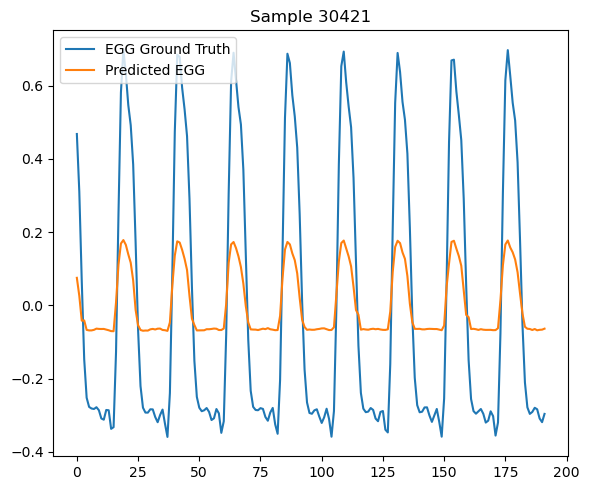

In [79]:
num_samples = 1
samples = np.random.randint(0, len(targets), size=num_samples)

plt.figure(figsize=(6, 5 * num_samples))
for i, sample in enumerate(samples, 1):
    plt.subplot(num_samples, 1, i)
    egg_sample = targets[sample].squeeze()
    output_sample = predictions[sample].squeeze()
    plt.plot(egg_sample, label='EGG Ground Truth')
    plt.plot(output_sample, label='Predicted EGG')
    plt.legend()
    plt.title(f'Sample {sample}')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming 'e' and 'output' are collected over the entire test dataset
# Collect predictions and targets in a list or directly in a tensor if memory allows
e_list = []
output_list = []
model.eval()
with torch.no_grad():
    for data in test_dataloader:
        a, e = data
        a = a.to(device)
        e = e.to(device)
        pred = model(a)
        e_list.append(e.cpu().numpy())
        output_list.append(pred.cpu().numpy())

# Convert lists to numpy arrays for easier manipulation
e_array = np.concatenate(e_list, axis=0)  # Adjust axis if necessary based on your data shape
output_array = np.concatenate(output_list, axis=0)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(e_array.flatten(), bins=50, alpha=0.5, label='Ground Truth (e)')
plt.hist(output_array.flatten(), bins=50, alpha=0.5, label='Predictions (output)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Comparison of Distribution between Ground Truth and Predictions')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(e_array.flatten(), output_array.flatten(), alpha=0.1)
plt.xlabel('Ground Truth (e)')
plt.ylabel('Predictions (output)')
plt.title('Scatter Plot of Predictions vs Ground Truth')
plt.plot([e_array.min(), e_array.max()], [e_array.min(), e_array.max()], 'r--')  # Diagonal line
plt.show()


In [ ]:
def predict_frames(frames, model, device):
    predicted_frames = np.zeros_like(frames)
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # No gradients needed
        for i in range(frames.shape[0]):
            frame = torch.from_numpy(frames[i, :]).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            frame = frame.to(device)  # Move to device
            output = model(frame)
            predicted_frames[i, :] = output.squeeze().cpu().numpy()  # Remove batch dimension and move to cpu
    return predicted_frames

def overlap_and_add(frames, hop_length, frame_length_ms):
    frame_length = int(samplerate * frame_length_ms / 1000)
    output_length = hop_length * (frames.shape[0] - 1) + frame_length
    output = np.zeros(output_length)
    window = np.hanning(frame_length)
    normalization = np.zeros(output_length)

    # 加和同时构建归一化数组
    for i in range(frames.shape[0]):
        start = i * hop_length
        end = start + frame_length
        output[start:end] += frames[i, :] * window
        normalization[start:end] += window

    # 避免除以零
    normalization[normalization == 0] = 1
    output /= normalization  # 归一化输出以保持原始信号幅度

    return output
# prediction
import matplotlib.pyplot as plt

# load the best model
model_path = r'Trial17_d0.5_stride1_F02_sr16_hanning_attention_channel128\models\best_model.pt'

# Instantiate the model
channels = 128  # You may need to tune this based on your dataset
model = WaveNet(input_channels=1, dilation_channels=channels)
model.load_state_dict(torch.load(model_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

audio_path = r'F:\audio\evaluation_audio\pathology\1-iau.wav'
egg_path = r'F:\audio\evaluation_audio\pathology\1-iau-egg.wav'
test_audio, sr = librosa.load(audio_path, sr=samplerate, mono=True)
test_egg, _ = librosa.load(egg_path, sr=samplerate, mono=True)

test_audio = test_audio[0:samplerate]
test_egg = test_egg[0:samplerate]

test_audio = voice_preprocess(test_audio, sr)
test_egg = process_EGG_signal(test_egg, sr)
test_audio = test_audio / np.max(np.abs(test_audio))
test_egg = test_egg / np.max(np.abs(test_egg))

test_audio_frames = segment_audio_temp(test_audio, samplerate, frame_length_ms, 1)
test_egg_frames = segment_audio_temp(test_egg, samplerate, frame_length_ms, 1)

predicted_test_egg_frames = predict_frames(test_audio_frames, model, device)
predicted_test_egg = overlap_and_add(predicted_test_egg_frames, hop_length_samples, frame_length_ms)


In [ ]:
# plot random frames
raw_index = np.random.randint(0, len(test_audio_frames))
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(test_audio_frames[raw_index])
plt.title("Audio Frame")
plt.subplot(2, 1, 2)
plt.plot(test_egg_frames[raw_index])    
plt.title("EGG Frame")
plt.tight_layout()
plt.show()

In [ ]:
# plot test_egg_frames
plt.figure()
plt.plot(predicted_test_egg)
plt.title('predicted_test_egg')
plt.show()


In [ ]:
import soundfile as sf

# save the predicted EGG using sf
sf.write('patho_test_egg.wav', test_egg, samplerate)
sf.write('patho_predicted_test_egg.wav', predicted_test_egg, samplerate)



In [63]:
def predict_frames(frames, model, device):
    predicted_frames = np.zeros_like(frames)
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # No gradients needed
        for i in range(frames.shape[0]):
            frame = torch.from_numpy(frames[i, :]).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            frame = frame.to(device)  # Move to device
            output = model(frame)
            predicted_frames[i, :] = output.squeeze().cpu().numpy()  # Remove batch dimension and move to cpu
    return predicted_frames

def overlap_and_add(frames, hop_length, frame_length_ms):
    frame_length = int(samplerate * frame_length_ms / 1000)
    output_length = hop_length * (frames.shape[0] - 1) + frame_length
    output = np.zeros(output_length)
    window = np.hanning(frame_length)
    normalization = np.zeros(output_length)

    # 加和同时构建归一化数组
    for i in range(frames.shape[0]):
        start = i * hop_length
        end = start + frame_length
        output[start:end] += frames[i, :] * window
        normalization[start:end] += window

    # 避免除以零
    normalization[normalization == 0] = 1
    output /= normalization  # 归一化输出以保持原始信号幅度

    return output

frame_length_ms = 12
# frame_length_samples = int(samplerate * frame_length_ms / 1000)
# hop_length = frame_length_samples // 2

# var repeatition
predict_audio_frames = segment_audio_temp(test_raw_audio, samplerate, frame_length_ms, hop_length_samples)
predicted_egg_frames = predict_frames(predict_audio_frames, model, device)
predicted_egg = overlap_and_add(predicted_egg_frames, hop_length_samples, frame_length_ms)

In [ ]:
# oncatenated predicted_egg_frames
predicted_egg_frames_c = np.concatenate(predicted_egg_frames)
test_egg_frames = segment_audio(test_egg, samplerate, frame_length_ms, hop_length_samples)
test_egg_frames_c = np.concatenate(test_egg_frames)
# plot predicted_egg_frames
plt.figure()
plt.plot(predicted_egg_frames_c)
plt.title('predicted_egg_frames')
plt.show()

# plot test_egg_frames
plt.figure()
plt.plot(test_egg_frames_c)
plt.title('test_egg_frames')
plt.show()


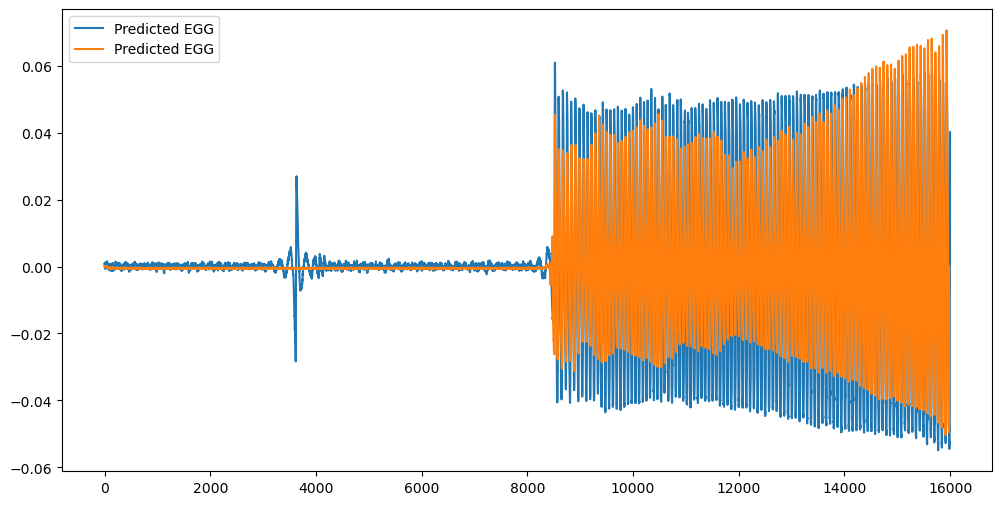

In [64]:
# Plot the first sample
plt.figure(figsize=(12, 6))
plt.plot(test_raw_egg, label='Predicted EGG')
plt.plot(predicted_egg, label='Predicted EGG')
plt.legend()
plt.show()


In [66]:
import soundfile as sf
# save wave to experiment folder
experiment_folder = os.path.join(base_dir, experiment_name)
sf.write(os.path.join(experiment_folder, 'predicted_egg.wav'), predicted_egg, samplerate)
sf.write(os.path.join(experiment_folder, 'test_egg.wav'), test_raw_egg, samplerate)

In [ ]:
# plot dEGG of the predicted EGG and the test EGG
dEGG_predicted = np.diff(predicted_egg_frames_c)
dEGG_test = np.diff(test_egg_frames_c)

plt.figure()
plt.plot(dEGG_predicted[3000:4000])
plt.title('dEGG_predicted')
plt.show()

plt.figure()
plt.plot(dEGG_test[3000:4000])
plt.title('dEGG_test')
plt.show()
